REFERENCE PAPERS

branch mlp : https://proceedings.mlr.press/v162/peng22a.html?ref=https://githubhelp.com

sklearn : @article{scikit-learn,
  title={Scikit-learn: Machine Learning in Python},
  author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
  journal={Journal of Machine Learning Research},
  volume={12},
  pages={2825--2830},
  year={2011}
}

adding common layer : https://proceedings.nips.cc/paper/2021/file/cba0a4ee5ccd02fda0fe3f9a3e7b89fe-Paper.pdf
                      https://arxiv.org/abs/2307.00592
                      https://arxiv.org/abs/2112.04453

XGBoost: https://dl.acm.org/doi/abs/10.1145/2939672.2939785

Random forests: https://link.springer.com/article/10.1023/a:1010933404324

residual blocks : https://ar5iv.org/html/2105.03404v2
                  https://arxiv.org/abs/2107.08391

L2 regularisation : https://www.researchgate.net/publication/215721451_Neural_Networks_For_Pattern_Recognition (DOI:10.1093/oso/9780198538493.001.0001)
                    https://dl.acm.org/doi/abs/10.1145/1015330.1015435


In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [7]:
full_path = 'data/2024-04-04_DVL1_test_data_for_refit.csv'
dvl1 = pd.read_csv(full_path, delimiter=',')
dvl1 = dvl1[dvl1['r_value'] != 0]

In [9]:
def map_steel_family(df):

    family_mapping = {
        # AHSS family
        '2F63': 'AHSS',
        '2F95': 'AHSS',
        '2Q91': 'AHSS',
        '3F63': 'AHSS',
        
        # CMn family
        '110E': 'CMn', '110F': 'CMn', '110H': 'CMn', '112H': 'CMn', 
        '112L': 'CMn', '114E': 'CMn', '116L': 'CMn', '125C': 'CMn',
        '126C': 'CMn', '126L': 'CMn', '180L': 'CMn', '180N': 'CMn',
        '184L': 'CMn', '184M': 'CMn', '186C': 'CMn', '187L': 'CMn',
        '180G': 'CMn', '111C': 'CMn', '114C': 'CMn', '114H': 'CMn',
        '121L': 'CMn', '1T46': 'CMn', '1T36': 'CMn', '1T86': 'CMn',
        '1S38': 'CMn', '1S42': 'CMn', '1T32': 'CMn', '1T80': 'CMn',
        '1T82': 'CMn', '1T34': 'CMn', '110B': 'CMn', '1P65': 'CMn',
        '184K': 'CMn', '1N47': 'CMn', '1N57': 'CMn', '123L': 'CMn',
        '115H': 'CMn', '1T44': 'CMn', '1T84': 'CMn', '1T94': 'CMn', 
        '115E': 'CMn', '1P85': 'CMn', 
        
        # HSLA family
        '1N80': 'HSLA', '1N31': 'HSLA', '1N60': 'HSLA', '1N61': 'HSLA',
        '1N81': 'HSLA', '1N91': 'HSLA', '1N84': 'HSLA', '1N64': 'HSLA',
        '1N94': 'HSLA', '1N32': 'HSLA', '1N33': 'HSLA', '1N62': 'HSLA',
        '1N63': 'HSLA', '1N82': 'HSLA', '1N83': 'HSLA', '1N92': 'HSLA',
        '1N93': 'HSLA', '1N36': 'HSLA', '1N37': 'HSLA', '1N66': 'HSLA',
        '1N67': 'HSLA', '1N86': 'HSLA', '1N87': 'HSLA', '1N96': 'HSLA',
        '1N97': 'HSLA', '1N38': 'HSLA', '1N39': 'HSLA', '1N68': 'HSLA',
        '1N69': 'HSLA', '1N88': 'HSLA', '1N98': 'HSLA', '1N99': 'HSLA',
        '3N73': 'HSLA', '3N73': 'HSLA',
        
        # IF family
        '514Z': 'IF', '515M': 'IF', '581G': 'IF', '590Q': 'IF',
        '590Z': 'IF', '591M': 'IF', '594Q': 'IF', '594Z': 'IF',
        '595M': 'IF', '542P': 'IF', '543P': 'IF', '544P': 'IF',
        '545P': 'IF', '540Z': 'IF', '541M': 'IF', '54AE': 'IF',
        '561P': 'IF', '592P': 'IF', '593P': 'IF', '598P': 'IF',
        '599P': 'IF', '59AD': 'IF', '552V': 'IF', '553V': 'IF',
        '589L': 'IF', '59TM': 'IF', '55AV': 'IF'
    }
    
    df_copy = df.copy()
    
    # Map steel family on the copy
    df_copy['steel_family'] = df_copy['steel_grade'].map(family_mapping)
    
    return df_copy

In [8]:
def remove_outliers(df):
    Q1 = df['r_value'].quantile(0.10)
    Q3 = df['r_value'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['r_value'] >= lower_bound) & (df['r_value'] <= upper_bound)]

In [10]:
dvl1 = map_steel_family(dvl1)
dvl1['steel_family'].value_counts()

steel_family
IF      6094
HSLA    5712
CMn     3901
Name: count, dtype: int64

In [12]:
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
desc = pd.read_excel(path, sheet_name=3)

tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count') | (desc['Input Type'] == 'Prediction - Calculation'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected = dvl1[existing_columns+["rm", "ag", "a80", "n_value",'r_value', 'steel_grade']]

c:\Users\A070050\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [8]:
# for i in features_selected[features_selected['Input Type'] == 'Prediction - Calculation']['Attribute Name'].to_list():
#     if i not in dvl1.columns:
#         print(i)

In [13]:
nan_cols = dvl1_selected.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant
cols_to_drop = nan_cols[nan_cols > 100].index.tolist()
dvl1_selected = dvl1_selected.drop(cols_to_drop, axis=1)
dvl1_selected.dropna(inplace=True)

In [14]:
corr_threshold = 0.2

corr = dvl1_selected.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected.columns) - len(selected_features)} columns')

dropped 24 columns


In [11]:
# Dropping steelgrade occurences that dont appear often (less than 5)
dvl1_selected = dvl1_selected[selected_features+['steel_grade']]
counts = dvl1_selected['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected = dvl1_selected[dvl1_selected['steel_grade'].isin(filtered_values)]
dvl1_selected = map_steel_family(dvl1_selected).drop(['steel_grade'], axis=1)
dvl1_selected = dvl1_selected.groupby('steel_family').apply(remove_outliers).reset_index(drop=True)

dvl1_selected

,cold_roll_reduction,elong_tl_pct,elong_tm_pct,gauge_f1,gauge_f2,gauge_f3,gauge_f4,gauge_f5,gauge_f6,gauge_f7,...,time_inter_f4,time_inter_f5,time_inter_f6,time_inter_f7,rm,ag,a80,n_value,r_value,steel_family
0,66.97,2.0,16.0,24.529786,16.663215,11.979636,9.008755,6.573885,5.513293,4.56455,...,1.710,1.300,1.050,0.850,393,20.0,39.0,0.181,1.15,CMn
1,67.88,2.0,0.0,26.053005,18.053067,12.849053,9.586975,7.760840,6.249673,4.72489,...,2.009,1.481,1.179,0.862,378,20.5,43.0,0.178,1.05,CMn
2,67.90,2.0,16.0,24.351294,16.750388,12.294898,9.102001,6.660000,5.530000,4.70891,...,2.029,1.516,1.229,1.005,366,22.5,40.0,0.200,1.15,CMn
3,72.38,2.0,16.0,21.690000,12.760000,8.450000,5.960000,4.410000,3.450000,2.90239,...,1.351,0.940,0.684,0.542,383,22.0,39.5,0.195,1.05,CMn
4,72.38,2.0,16.0,20.780000,12.730000,8.530000,5.900000,4.410000,3.440000,2.89543,...,1.330,0.934,0.687,0.545,384,22.0,39.0,0.194,1.05,CMn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15591,78.13,1.0,15.0,26.590000,17.980000,12.760000,9.440000,7.160000,5.550000,3.80039,...,1.213,0.882,0.673,0.514,314,19.5,34.0,0.185,1.50,IF
15592,73.90,1.0,13.0,28.973028,20.959475,15.100574,11.654747,9.185976,7.139899,5.76871,...,1.470,1.120,0.870,0.700,307,21.0,40.5,0.193,1.65,IF
15593,80.32,1.0,15.0,26.670000,17.900000,12.060000,8.490000,6.530000,5.120000,4.37135,...,1.411,0.996,0.755,0.582,290,23.5,47.5,0.217,2.20,IF
15594,80.32,1.0,15.0,27.028830,18.710170,12.928046,9.371886,7.225700,5.603521,4.39936,...,1.481,1.049,0.790,0.610,294,23.5,43.0,0.215,2.15,IF


In [12]:
# labeling the features for each branch
features = [col for col in dvl1_selected.columns if col not in ['r_value', 'steel_family']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(dvl1_selected, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [14]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)



In [ ]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim=None, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim),
            'model': create_residual_branch(model_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model=None):
        processed_branches = []
        branch_inputs_and_names = [
            ('chemical', chemical, self.branches['chemical']),
            ('time', time, self.branches['time']),
            ('process', process, self.branches['process']),
            ('model', model, self.branches['model'])
        ]
        
        for name, input_tensor, branch in branch_inputs_and_names:
            if branch is not None and input_tensor is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


# The ResidualBlock class remains unchanged
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [16]:
def train_family_models_enhanced(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = EnhancedMultiBranchRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hyperparameters=hyperparameters  # Pass the entire hyperparameters dictionary
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [17]:
def train_family_models_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hidden_units=hyperparameters['hidden_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [18]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64],
    'hidden_units': [64, 128],
    'dropout_rate': [0, 0.2],
    'cross_branch_dropout': [0, 0.2],
    'final_layer_units': [
        [128, 64],
        [256, 128],
    ],
    'final_layer_dropout': [
        [0, 0],
        [0.2, 0.2],
    ],
    'normalization': ['batch', 'layer']
}
grid = ParameterGrid(param_grid)

In [19]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models_enhanced(train_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [20]:
# best_results = {'avg_r2': 0.5774655195501973,
#  'evaluation_results': {'CMn': {'test_loss': 0.057762887328863144,
#    'r2_score': 0.543479086418242},
#   'HSLA': {'test_loss': 0.024983583018183708, 'r2_score': 0.718411446680632},
#   'IF': {'test_loss': 0.12141738831996918, 'r2_score': 0.47050602555171783}}}

In [21]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

In [22]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
}

In [23]:
family_models, eval_regular = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1885
Epoch [20/100], Loss: 0.1701
Epoch [30/100], Loss: 0.1645
Epoch [40/100], Loss: 0.1563
Epoch [50/100], Loss: 0.1571
Epoch [60/100], Loss: 0.1514
Epoch [70/100], Loss: 0.1479
Epoch [80/100], Loss: 0.1481
Epoch [90/100], Loss: 0.1463
Epoch [100/100], Loss: 0.1431
Evaluation for CMn - Test Loss: 0.1428, R2: 0.6675
Epoch [10/100], Loss: 0.2472
Epoch [20/100], Loss: 0.2304
Epoch [30/100], Loss: 0.2181
Epoch [40/100], Loss: 0.2153
Epoch [50/100], Loss: 0.2128
Epoch [60/100], Loss: 0.2076
Epoch [70/100], Loss: 0.2028
Epoch [80/100], Loss: 0.2025
Epoch [90/100], Loss: 0.1978
Epoch [100/100], Loss: 0.1988
Evaluation for IF - Test Loss: 0.2097, R2: 0.6230
Epoch [10/100], Loss: 0.1553
Epoch [20/100], Loss: 0.1386
Epoch [30/100], Loss: 0.1246
Epoch [40/100], Loss: 0.1234
Epoch [50/100], Loss: 0.1205
Epoch [60/100], Loss: 0.1159
Epoch [70/100], Loss: 0.1164
Epoch [80/100], Loss: 0.1129
Epoch [90/100], Loss: 0.1135
Epoch [100/100], Loss: 0.1110
Evaluation for HSLA - Test

In [24]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category]
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](**input_tensors).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

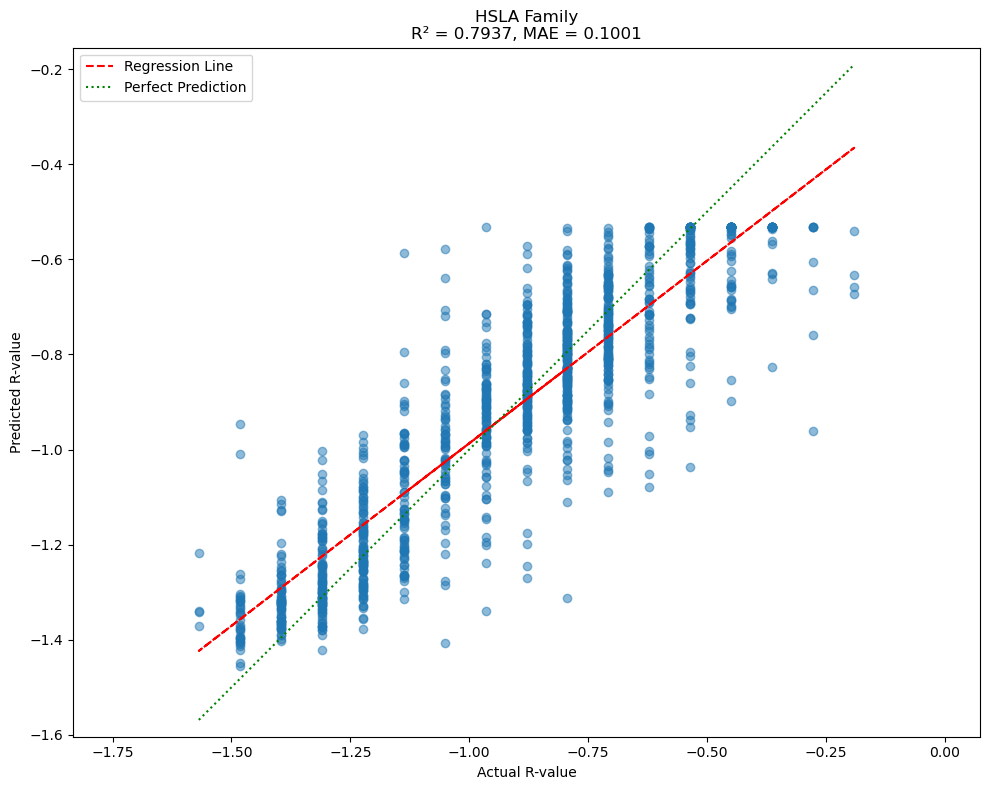

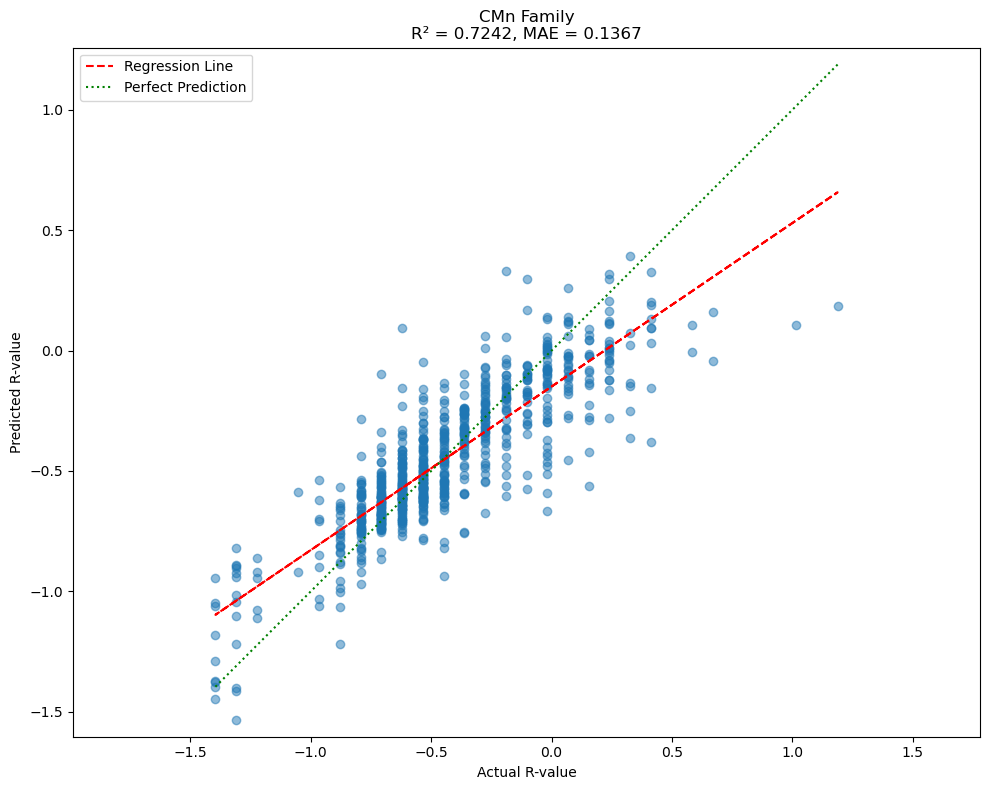

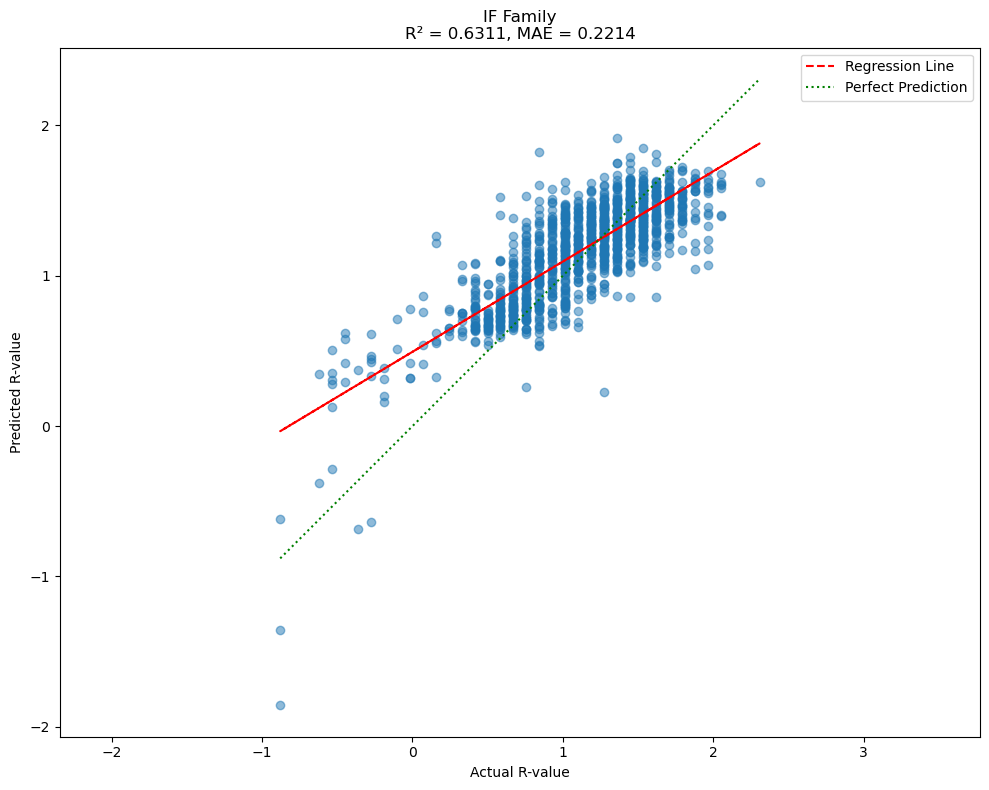

In [25]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [26]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
 'l2_lambda': 0.001
}

In [27]:
family_models_enhanced, eval_enhanced = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params_grid)

Epoch [10/100], Loss: 0.1429
Epoch [20/100], Loss: 0.1226
Epoch [30/100], Loss: 0.1103
Epoch [40/100], Loss: 0.0983
Epoch [50/100], Loss: 0.0905
Epoch [60/100], Loss: 0.0838
Epoch [70/100], Loss: 0.0796
Epoch [80/100], Loss: 0.0691
Epoch [90/100], Loss: 0.0711
Epoch [100/100], Loss: 0.0626
Evaluation for CMn - Test Loss: 0.1456, R2: 0.6208
Epoch [10/100], Loss: 0.2033
Epoch [20/100], Loss: 0.1839
Epoch [30/100], Loss: 0.1739
Epoch [40/100], Loss: 0.1637
Epoch [50/100], Loss: 0.1533
Epoch [60/100], Loss: 0.1404
Epoch [70/100], Loss: 0.1320
Epoch [80/100], Loss: 0.1197
Epoch [90/100], Loss: 0.1077
Epoch [100/100], Loss: 0.0985
Evaluation for IF - Test Loss: 0.2208, R2: 0.5840
Epoch [10/100], Loss: 0.1040
Epoch [20/100], Loss: 0.0902
Epoch [30/100], Loss: 0.0873
Epoch [40/100], Loss: 0.0786
Epoch [50/100], Loss: 0.0728
Epoch [60/100], Loss: 0.0689
Epoch [70/100], Loss: 0.0666
Epoch [80/100], Loss: 0.0597
Epoch [90/100], Loss: 0.0548
Epoch [100/100], Loss: 0.0514
Evaluation for HSLA - Test

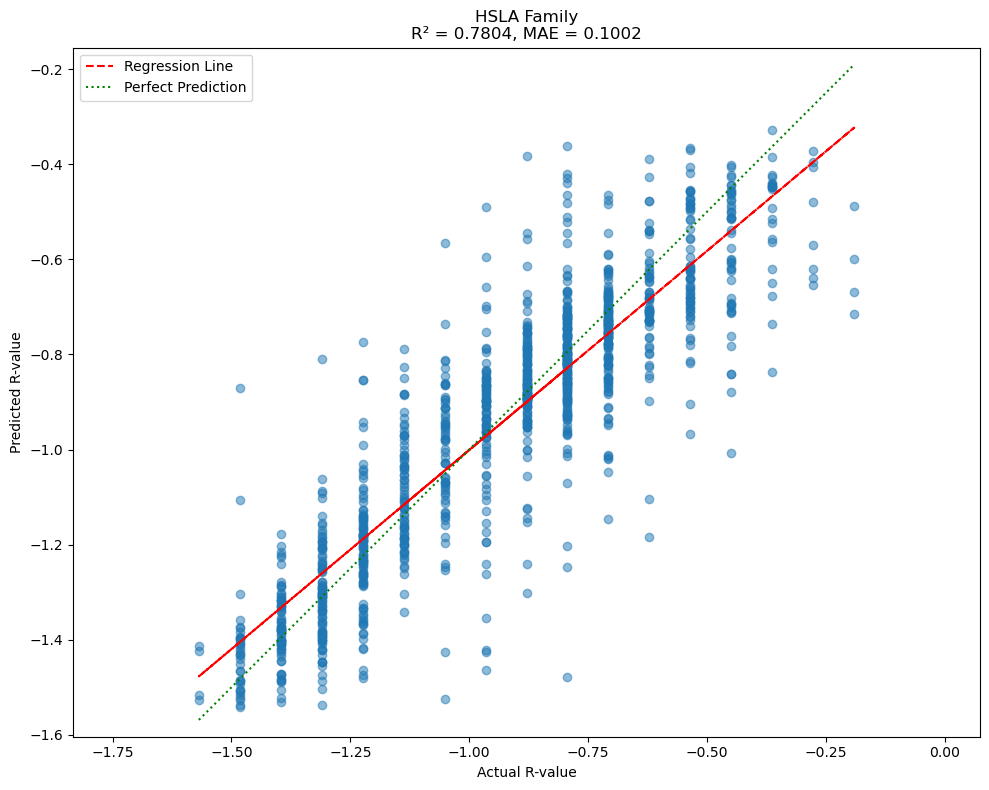

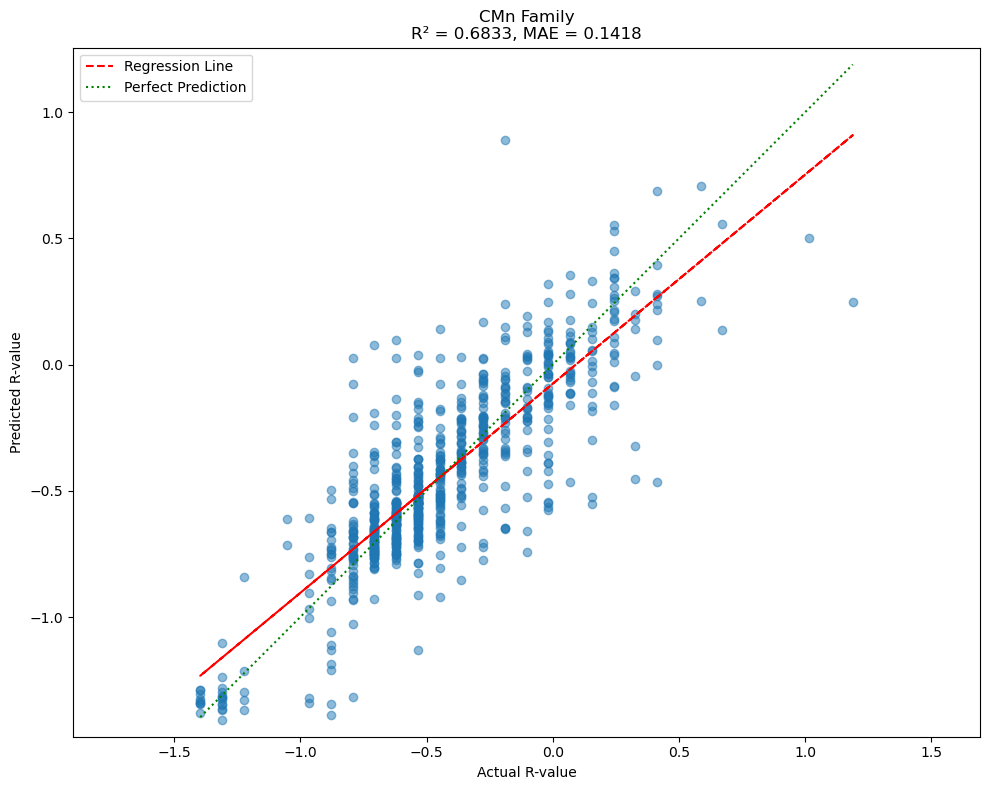

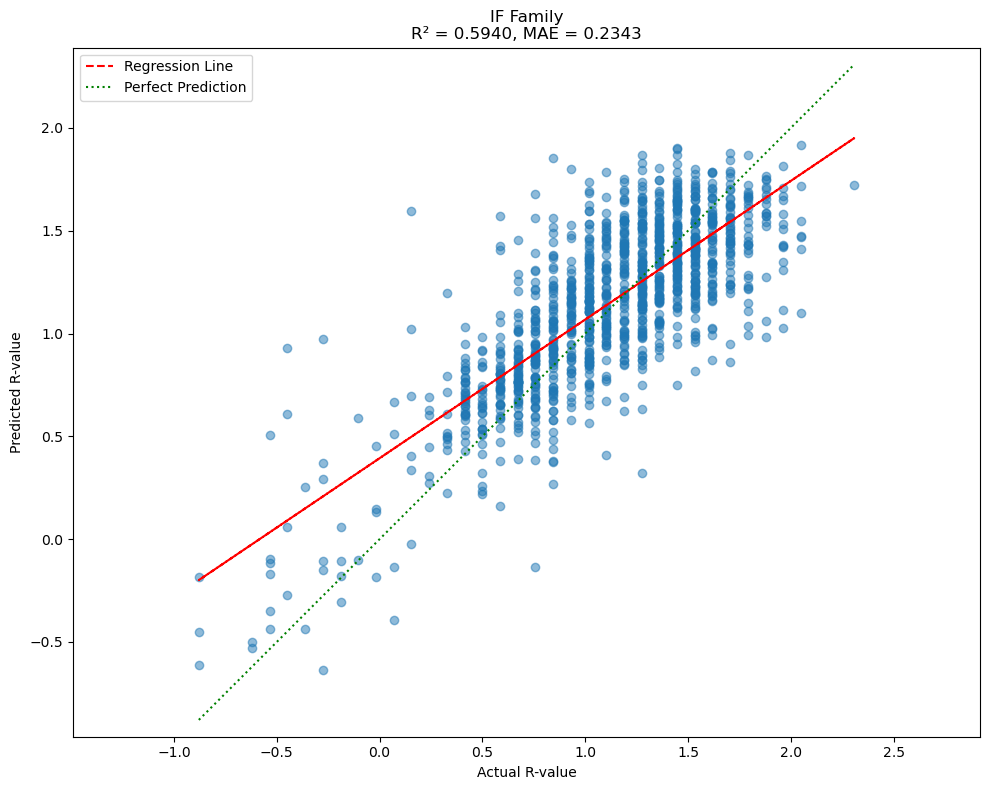

In [28]:
plot_actual_vs_predicted(test_scaled_df, family_models_enhanced, features_dict)

In [29]:
tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected_no_mecomep = dvl1[existing_columns+['r_value', 'steel_grade']]

nan_cols = dvl1_selected_no_mecomep.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant
cols_to_drop = nan_cols[nan_cols > 100].index.tolist()
dvl1_selected_no_mecomep = dvl1_selected_no_mecomep.drop(cols_to_drop, axis=1)
dvl1_selected_no_mecomep.dropna(inplace=True)

corr_threshold = 0.2

corr = dvl1_selected_no_mecomep.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected_no_mecomep.columns) - len(selected_features)} columns')

# Dropping steelgrade occurences that dont appear often (less than 5)
dvl1_selected_no_mecomep = dvl1_selected_no_mecomep[selected_features+['steel_grade']]
counts = dvl1_selected_no_mecomep['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected_no_mecomep = dvl1_selected_no_mecomep[dvl1_selected_no_mecomep['steel_grade'].isin(filtered_values)]
dvl1_selected_no_mecomep = map_steel_family(dvl1_selected_no_mecomep).drop(['steel_grade'], axis=1)
dvl1_selected_no_mecomep = dvl1_selected_no_mecomep.groupby('steel_family').apply(remove_outliers).reset_index(drop=True)

dropped 24 columns


In [30]:
# Split first to avoid data leakage
train_df, test_df = train_test_split(dvl1_selected_no_mecomep, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [31]:
family_models, eval_regular_no_model = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.2020
Epoch [20/100], Loss: 0.1844
Epoch [30/100], Loss: 0.1782
Epoch [40/100], Loss: 0.1734
Epoch [50/100], Loss: 0.1680
Epoch [60/100], Loss: 0.1676
Epoch [70/100], Loss: 0.1664
Epoch [80/100], Loss: 0.1637
Epoch [90/100], Loss: 0.1603
Epoch [100/100], Loss: 0.1601
Evaluation for CMn - Test Loss: 0.1620, R2: 0.5752
Epoch [10/100], Loss: 0.2661
Epoch [20/100], Loss: 0.2534
Epoch [30/100], Loss: 0.2428
Epoch [40/100], Loss: 0.2367
Epoch [50/100], Loss: 0.2387
Epoch [60/100], Loss: 0.2357
Epoch [70/100], Loss: 0.2333
Epoch [80/100], Loss: 0.2284
Epoch [90/100], Loss: 0.2263
Epoch [100/100], Loss: 0.2271
Evaluation for IF - Test Loss: 0.2524, R2: 0.4094
Epoch [10/100], Loss: 0.1568
Epoch [20/100], Loss: 0.1406
Epoch [30/100], Loss: 0.1328
Epoch [40/100], Loss: 0.1282
Epoch [50/100], Loss: 0.1259
Epoch [60/100], Loss: 0.1255
Epoch [70/100], Loss: 0.1262
Epoch [80/100], Loss: 0.1227
Epoch [90/100], Loss: 0.1213
Epoch [100/100], Loss: 0.1198
Evaluation for HSLA - Test

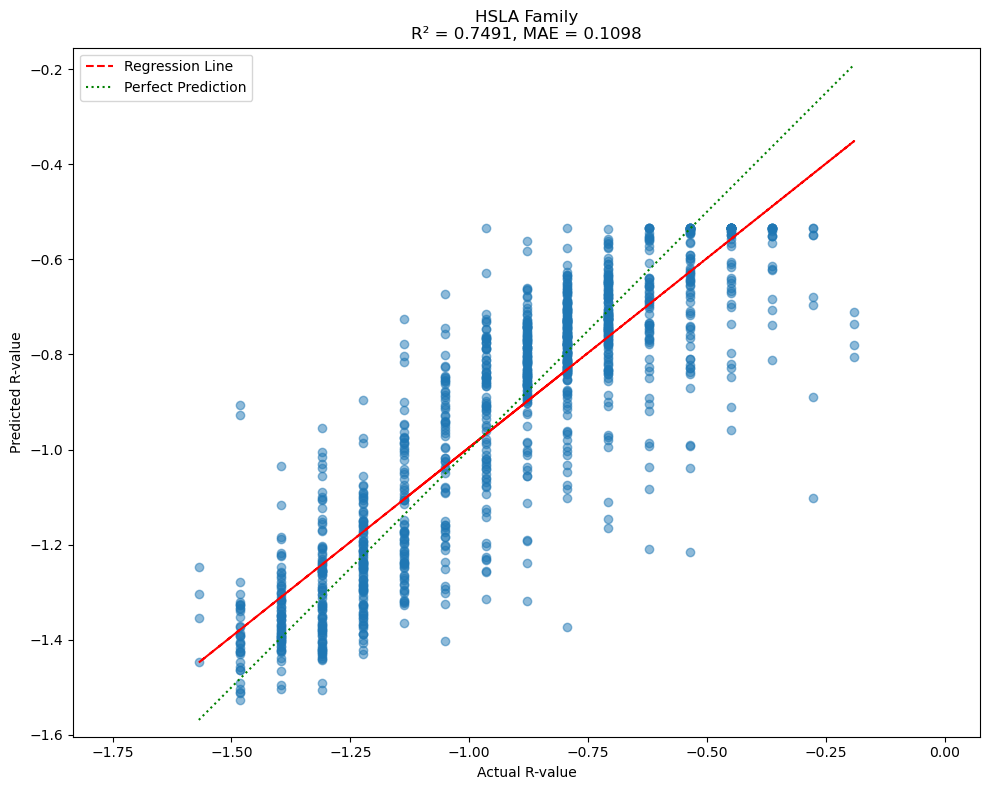

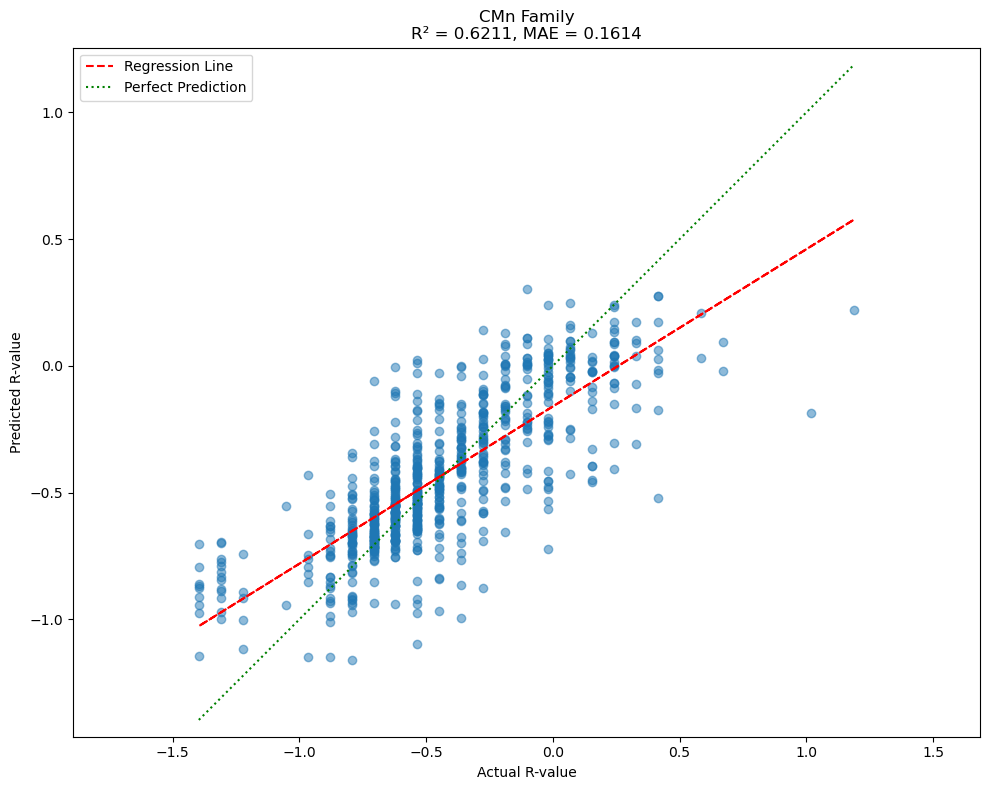

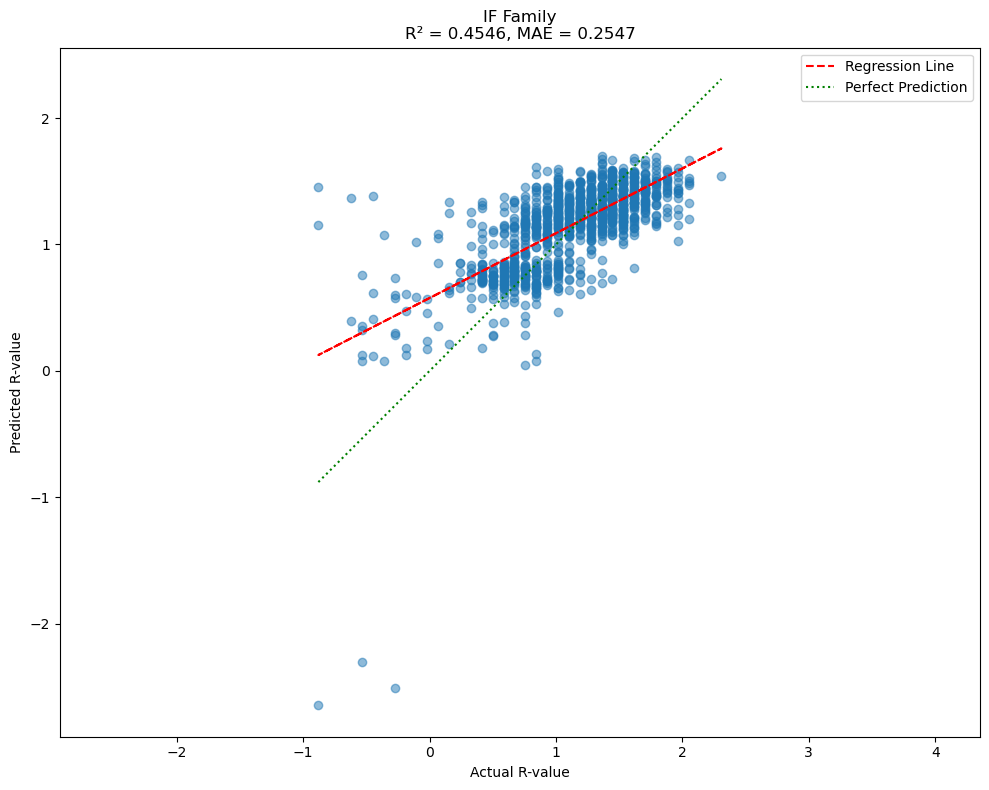

In [32]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [33]:
family_models, eval_enhanced_no_model = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1609
Epoch [20/100], Loss: 0.1444
Epoch [30/100], Loss: 0.1333
Epoch [40/100], Loss: 0.1204
Epoch [50/100], Loss: 0.1123
Epoch [60/100], Loss: 0.1049
Epoch [70/100], Loss: 0.0975
Epoch [80/100], Loss: 0.0903
Epoch [90/100], Loss: 0.0847
Epoch [100/100], Loss: 0.0807
Evaluation for CMn - Test Loss: 0.1739, R2: 0.4732
Epoch [10/100], Loss: 0.2299
Epoch [20/100], Loss: 0.2158
Epoch [30/100], Loss: 0.2067
Epoch [40/100], Loss: 0.1901
Epoch [50/100], Loss: 0.1844
Epoch [60/100], Loss: 0.1722
Epoch [70/100], Loss: 0.1632
Epoch [80/100], Loss: 0.1499
Epoch [90/100], Loss: 0.1413
Epoch [100/100], Loss: 0.1325
Evaluation for IF - Test Loss: 0.2769, R2: 0.3616
Epoch [10/100], Loss: 0.1103
Epoch [20/100], Loss: 0.1007
Epoch [30/100], Loss: 0.0930
Epoch [40/100], Loss: 0.0867
Epoch [50/100], Loss: 0.0824
Epoch [60/100], Loss: 0.0771
Epoch [70/100], Loss: 0.0719
Epoch [80/100], Loss: 0.0671
Epoch [90/100], Loss: 0.0632
Epoch [100/100], Loss: 0.0604
Evaluation for HSLA - Test

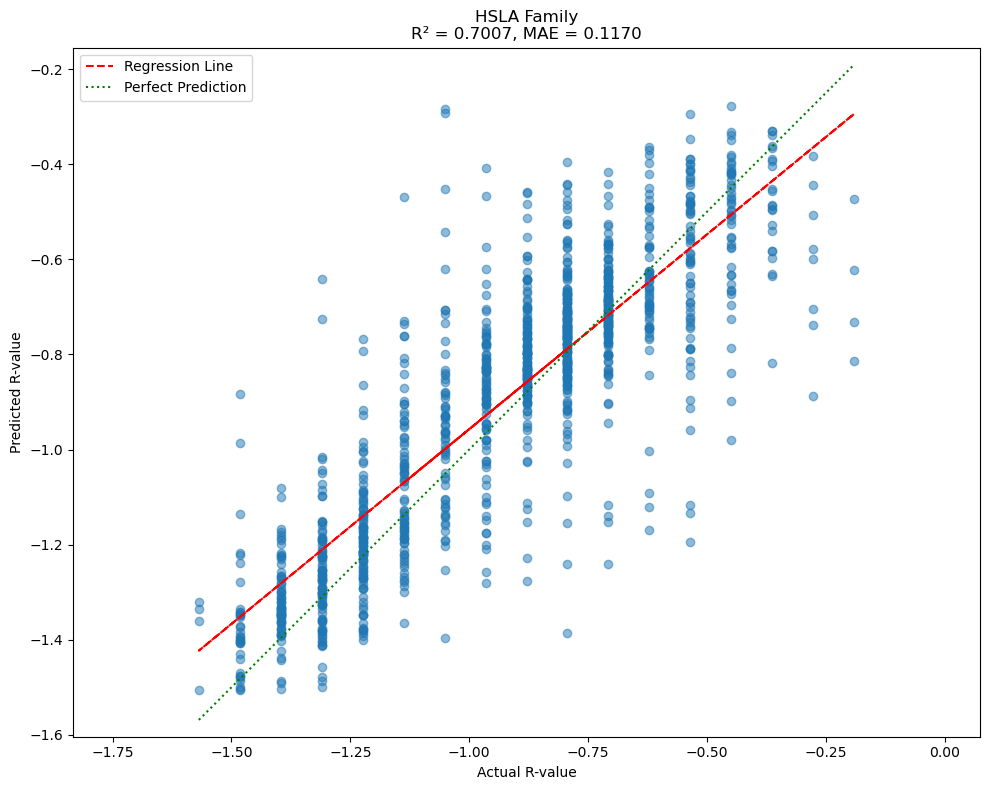

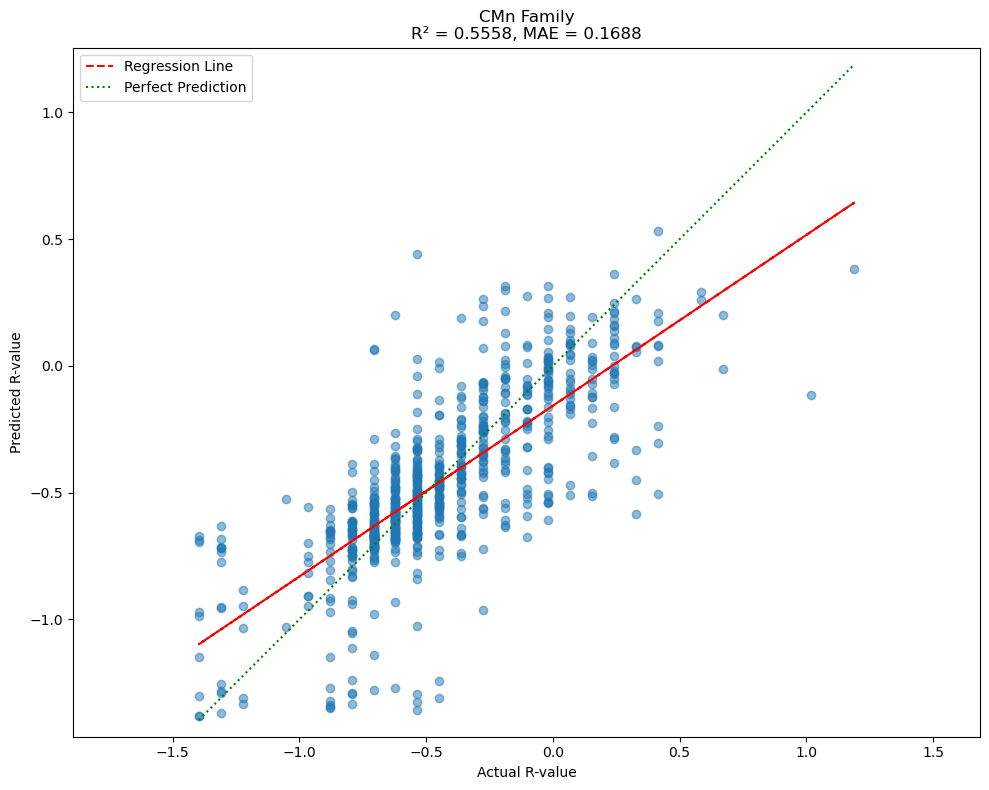

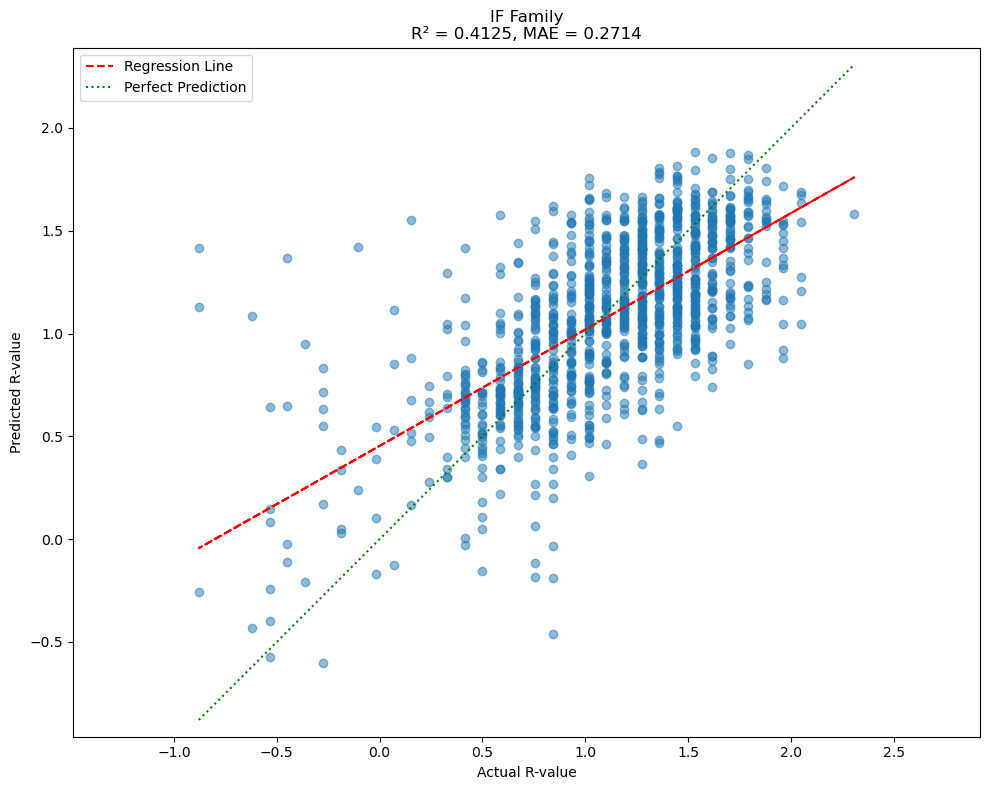

In [35]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [40]:
eval_regular_no_model

{'CMn': {'test_loss': 0.16195623576641083, 'r2_score': 0.5751770081463637},
 'IF': {'test_loss': 0.25237515568733215, 'r2_score': 0.4093819285782113},
 'HSLA': {'test_loss': 0.1086718887090683, 'r2_score': 0.7248866460855964}}

In [ ]:
all_models = {'regular': eval_regular, 'regular_no_model_output': eval_regular_no_model, 'enhanced': eval_enhanced, 'enhanced_no_model_output': eval_enhanced_no_model}
data = []
for model, metrics in all_models.items():
    for category, values in metrics.items():
        data.append({
            'Model': model,
            'Steel family': category,
            'r2_score': values['r2_score']
        })
df = pd.DataFrame(data)
df

,Model,Steel family,r2_score
0,regular,CMn,0.667507
1,regular,IF,0.622983
2,regular,HSLA,0.782120
3,regular_no_model_output,CMn,0.575177
4,regular_no_model_output,IF,0.409382
5,regular_no_model_output,HSLA,0.724887
6,enhanced,CMn,0.620834
7,enhanced,IF,0.584002
8,enhanced,HSLA,0.746620
9,enhanced_no_model_output,CMn,0.473163


In [49]:
df.to_csv('results_mlp.csv', index=False) 

In [50]:
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)

# Optionally, save the merged dataframe to a new CSV
merged_df.to_csv('merged_results.csv', index=False)

In [51]:
merged_df

,Model,Steel family,r2_score
0,regular,CMn,0.667507
1,regular,IF,0.622983
2,regular,HSLA,0.782120
3,regular_no_model_output,CMn,0.575177
4,regular_no_model_output,IF,0.409382
5,regular_no_model_output,HSLA,0.724887
6,enhanced,CMn,0.620834
7,enhanced,IF,0.584002
8,enhanced,HSLA,0.746620
9,enhanced_no_model_output,CMn,0.473163
